In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택


# %% [code]
!unzip snownsand.zip -d snownsand/    #catanddog 폴더 만들어 압축 풀기

Saving snownsand.zip to snownsand (1).zip
Archive:  snownsand.zip
replace snownsand/test/sandstorm/2943.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: snownsand/test/sandstorm/2943.jpg  
  inflating: snownsand/test/sandstorm/2944.jpg  
  inflating: snownsand/test/sandstorm/2945.jpg  
  inflating: snownsand/test/sandstorm/2946.jpg  
  inflating: snownsand/test/sandstorm/2947.jpg  
  inflating: snownsand/test/sandstorm/2948.jpg  
  inflating: snownsand/test/sandstorm/2949.jpg  
  inflating: snownsand/test/sandstorm/3019.jpg  
  inflating: snownsand/test/sandstorm/3020.jpg  
  inflating: snownsand/test/sandstorm/3021.jpg  
  inflating: snownsand/test/sandstorm/3022.jpg  
  inflating: snownsand/test/sandstorm/3023.jpg  
  inflating: snownsand/test/sandstorm/3024.jpg  
  inflating: snownsand/test/sandstorm/3025.jpg  
  inflating: snownsand/test/sandstorm/3026.jpg  
  inflating: snownsand/test/sandstorm/3027.jpg  
  inflating: snownsand/test/sandstorm/3028.jpg  
  inflating: snown

445
213


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

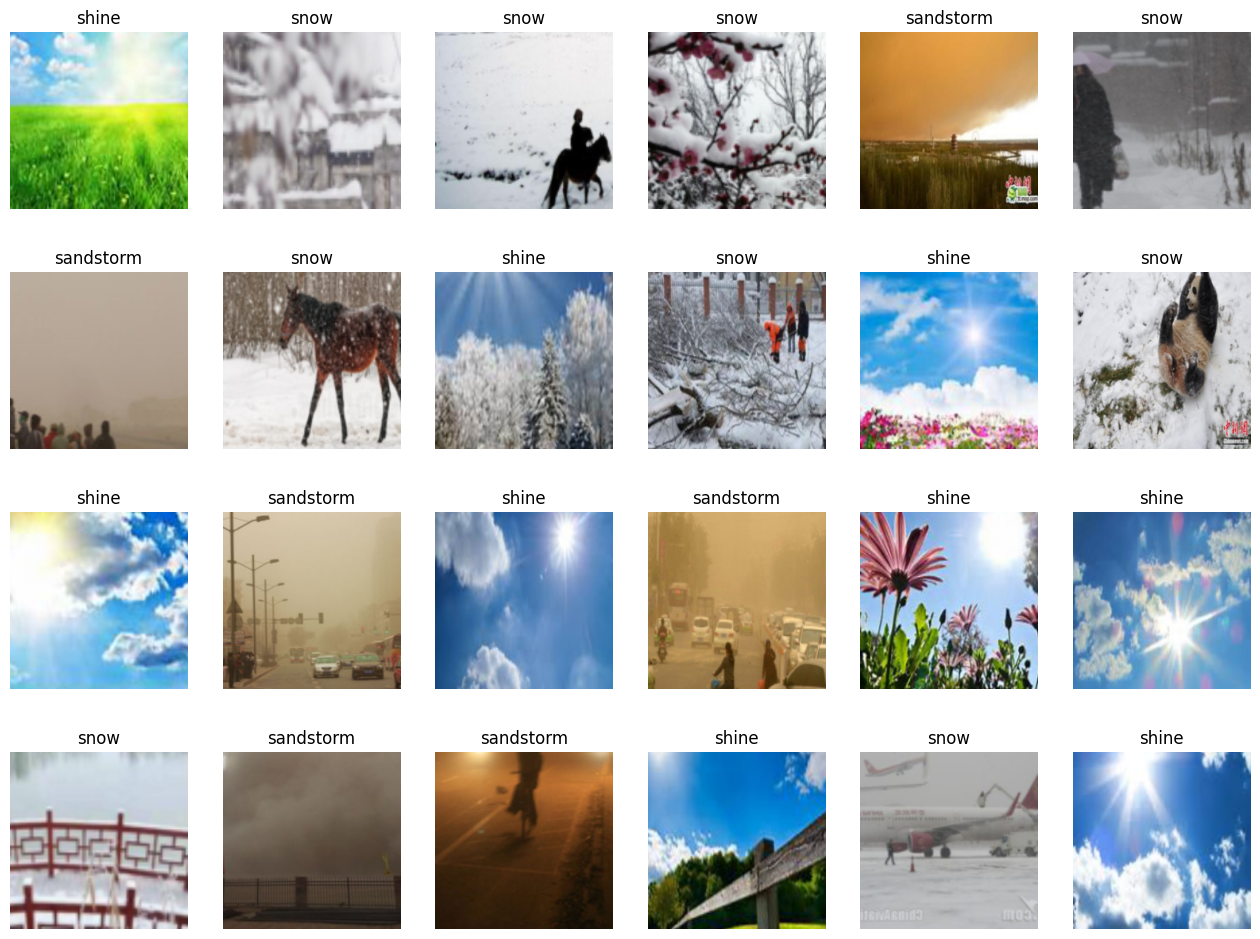

In [6]:
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset 구축

# train dataset
data_path = 'snownsand/train/'
transform = transforms.Compose([
    transforms.Resize([256, 256]),  # 이미지 크기 조정
    transforms.RandomResizedCrop(224),  # 임의로 이미지를 잘라내어 크기를 조정
    transforms.RandomHorizontalFlip(),  # 이미지를 수평으로 무작위로 뒤집기
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

# test dataset
test_path = 'snownsand/test/'
transform = transforms.Compose([
    transforms.Resize(224),  # 이미지 크기 조정
    transforms.CenterCrop(224),  # 이미지 중앙을 기준으로 잘라내기
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

# check dataset
samples, labels = next(iter(train_loader))
classes = {0: 'sandstorm', 1: 'shine', 2: 'snow'}
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

# 모델 변경 가능
resnet18 = models.resnet18(pretrained=True)

# 미세 조정할 파라미터 설정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

resnet18.fc = nn.Linear(512, 2)

# 모델 정의 및 파라미터 초기화
model = models.resnet18(pretrained=True)

# 미세 조정할 파라미터를 제외한 모든 파라미터를 고정
for param in model.parameters():
    param.requires_grad = False

# 분류기를 위한 fully connected layer를 변경하여 초기화
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

# Transfer Learning을 위해 업데이트할 파라미터 설정
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)


FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=3, bias=True)
)
Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 35.1723 Acc: 0.6966

Epoch 1/14
----------
Loss: 11.6631 Acc: 0.8180

Epoch 2/14
----------
Loss: 15.0258 Acc: 0.7978

Epoch 3/14
----------
Loss: 17.9296 Acc: 0.8292

Epoch 4/14
----------
Loss: 7.9915 Acc: 0.8494

Epoch 5/14
----------
Loss: 6.0286 Acc: 0.8202

Epoch 6/14
----------
Loss: 4.9641 Acc: 0.8719

Epoch 7/14
----------
Loss: 2.0133 Acc: 0.9213

Epoch 8/14
----------
Loss: 2.7915 Acc: 0.9101

Epoch 9/14
----------
Loss: 2.1360 Acc: 0.8989

Epoch 10/14
----------
Loss: 1.8703 Acc: 0.8787

Epoch 11/14
----------
Loss: 1.5321 Acc: 0.9034

Epoch 12/14
----------
Loss: 1.4601 Acc: 0.9034

Epoch 13/14
----------
Loss: 1.1378 Acc: 0.8944

Epoch 14/14
----------
Loss: 1.3390 Acc: 0.9101

Training complete in 1m 49s
Best Acc: 0.9213
saved_model ['snownsand/00.pth', 'snownsand/01.pth', 'snownsand/02.pth', 'snownsand/03.pth', 'snownsand/04.pth', 'snownsand/05.pth', 'snownsand/06.pth', 'snownsand/07.pth', 'snownsand/08.pth', 'snownsand/09.pth', 'snownsand/10.pth', 'snownsand/11.p

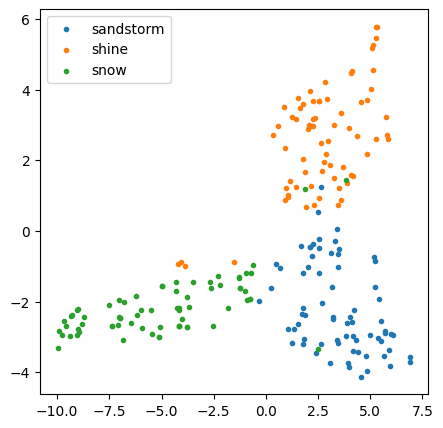

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 0.7223 Acc: 0.9236

Epoch 1/14
----------
Loss: 0.9278 Acc: 0.8899

Epoch 2/14
----------
Loss: 0.6713 Acc: 0.8921

Epoch 3/14
----------
Loss: 0.8507 Acc: 0.9101

Epoch 4/14
----------
Loss: 0.5071 Acc: 0.9056

Epoch 5/14
----------
Loss: 0.5380 Acc: 0.9056

Epoch 6/14
----------
Loss: 0.3319 Acc: 0.9169

Epoch 7/14
----------
Loss: 0.3236 Acc: 0.9146

Epoch 8/14
----------
Loss: 0.1953 Acc: 0.9303

Epoch 9/14
----------
Loss: 0.2075 Acc: 0.9416

Epoch 10/14
----------
Loss: 0.2538 Acc: 0.9169

Epoch 11/14
----------
Loss: 0.2078 Acc: 0.9303

Epoch 12/14
----------
Loss: 0.1706 Acc: 0.9461

Epoch 13/14
----------
Loss: 0.2591 Acc: 0.9348

Epoch 14/14
----------
Loss: 0.2004 Acc: 0.9461

Training complete in 1m 33s
Best Acc: 0.9461
saved_model ['snownsand/00.pth', 'snownsand/01.pth', 'snownsand/02.pth', 'snownsand/03.pth', 'snownsand/04.pth', 'snownsand/05.pth', 'snownsand/06.pth', 'snownsand/07.pth', 'snownsand/08.pth', 'snownsand/09.pth', 'snownsand/10.pth', 'snownsand/11.pth',

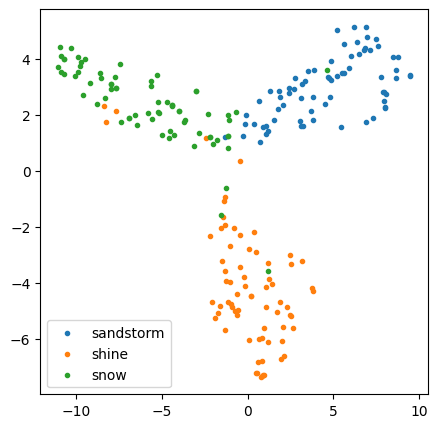

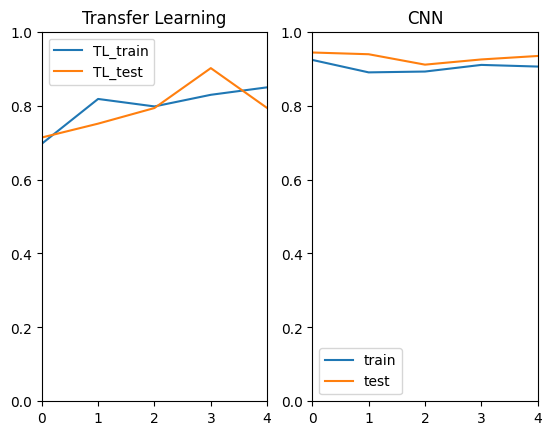

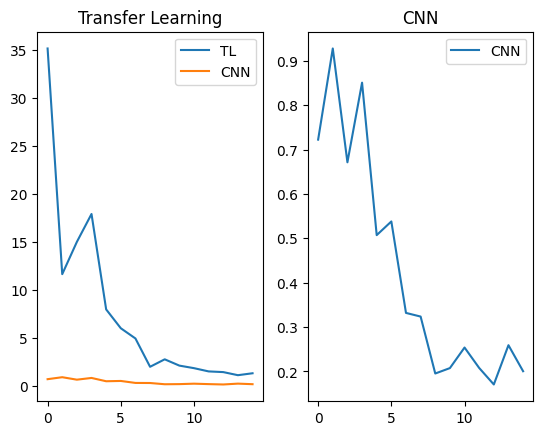

In [7]:
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import glob
from sklearn.manifold import TSNE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CNN 모델 정의
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64 * 55 * 55, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# CNN 모델을 GPU로 이동
model = FashionCNN()
model.to(device)

# 손실 함수, 옵티마이저 정의
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)


# Training과 Test를 위한 함수 정의
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=15, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('snownsand/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))
    return acc_history, loss_history


def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('snownsand/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history

# 전이 학습 training
TL_train_acc_hist, TL_train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

# 전이 학습 test
TL_val_acc_hist = eval_model(model, test_loader, device)

# 전이 학습 TSNE
actual = []
deep_features = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=3, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['sandstorm', 'shine', 'snow']
for i, label in zip(range(3), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()


# CNN training
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

# CNN test
val_acc_hist = eval_model(model, test_loader, device)


# CNN TSNE
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

tsne = TSNE(n_components=3, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['sandstorm', 'shine', 'snow']
for i, label in zip(range(3), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

plt.subplot(121)
plt.plot(TL_train_acc_hist, label="TL_train")
plt.plot(TL_val_acc_hist, label="TL_test")
plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
plt.title("Transfer Learning")

plt.subplot(122)
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="test")
plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
plt.title("CNN")

plt.show()


plt.subplot(121)
plt.plot(TL_train_loss_hist, label="TL")
plt.plot(train_loss_hist, label="CNN")
# plt.xlim([0, 4])
# plt.ylim([0, 1])
plt.legend()
plt.title("Transfer Learning")

plt.subplot(122)
plt.plot(train_loss_hist, label="CNN")
# plt.xlim([0, 4])
# plt.ylim([0, 1])
plt.legend()
plt.title("CNN")

plt.show()
